In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import torch
import numpy as np
import scipy.io as sio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm import tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

In [13]:
class MallFrameDataset(Dataset):
    def __init__(self, frames_dir, gt_counts):
        self.frames = sorted([
            f for f in os.listdir(frames_dir)
            if f.lower().endswith(".jpg")
        ])
        self.frames_dir = frames_dir
        self.gt = gt_counts

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.frames_dir, self.frames[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (1024, 768))
        img = img / 255.0
        img = torch.tensor(img).permute(2, 0, 1).float()

        gt_count = torch.tensor(self.gt[idx]).float()
        return img, gt_count


In [14]:
MALL_ROOT = "/content/drive/MyDrive/deepvision/mall_dataset"
FRAMES_DIR = os.path.join(MALL_ROOT, "frames")

gt_data = sio.loadmat(os.path.join(MALL_ROOT, "mall_gt.mat"))
gt_counts = gt_data["count"].squeeze()

train_dataset = MallFrameDataset(FRAMES_DIR, gt_counts)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [15]:
model = CSRNet().to(device)
CKPT = "/content/drive/MyDrive/deepvision/checkpoints/best_finetuned.pth"

model.load_state_dict(
    torch.load(CKPT, map_location=device)
)

print("Trained CSRNet loaded")

# Define loss and optimizer AFTER loading weights
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

#Training setup
EPOCHS = 5
TRAIN_SAVE_DIR = "/content/drive/MyDrive/deeovision/CSRNet_Training_Outputs"
os.makedirs(TRAIN_SAVE_DIR, exist_ok=True)

#Fine-tuning loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, gt in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, gt = imgs.to(device), gt.to(device)

        optimizer.zero_grad()
        density = model(imgs)
        pred_count = density.sum(dim=[1,2,3])

        loss = criterion(pred_count, gt)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    save_path = f"{TRAIN_SAVE_DIR}/csrnet_mall_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)

    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.3f}")
    print(f"Model saved at: {save_path}")


Trained CSRNet loaded


Epoch 1: 100%|██████████| 2000/2000 [15:52<00:00,  2.10it/s]


Epoch 1 | Avg Loss: 17.977
Model saved at: /content/drive/MyDrive/deeovision/CSRNet_Training_Outputs/csrnet_mall_epoch_1.pth


Epoch 2: 100%|██████████| 2000/2000 [15:11<00:00,  2.19it/s]


Epoch 2 | Avg Loss: 10.302
Model saved at: /content/drive/MyDrive/deeovision/CSRNet_Training_Outputs/csrnet_mall_epoch_2.pth


Epoch 3: 100%|██████████| 2000/2000 [15:11<00:00,  2.19it/s]


Epoch 3 | Avg Loss: 7.396
Model saved at: /content/drive/MyDrive/deeovision/CSRNet_Training_Outputs/csrnet_mall_epoch_3.pth


Epoch 4: 100%|██████████| 2000/2000 [15:10<00:00,  2.20it/s]


Epoch 4 | Avg Loss: 6.417
Model saved at: /content/drive/MyDrive/deeovision/CSRNet_Training_Outputs/csrnet_mall_epoch_4.pth


Epoch 5: 100%|██████████| 2000/2000 [15:12<00:00,  2.19it/s]

Epoch 5 | Avg Loss: 5.020
Model saved at: /content/drive/MyDrive/deeovision/CSRNet_Training_Outputs/csrnet_mall_epoch_5.pth


In [16]:
MODEL_PATH = f"{TRAIN_SAVE_DIR}/csrnet_mall_epoch_5.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Trained model loaded for testing")


Trained model loaded for testing


In [17]:
model.eval()
all_preds = []

with torch.no_grad():
    for imgs, gt in tqdm(train_loader, desc="Evaluating MAE"):
        imgs = imgs.to(device)

        density_maps = model(imgs)
        batch_counts = density_maps.sum(dim=(1, 2, 3))

        all_preds.extend(batch_counts.cpu().numpy())

all_preds = np.array(all_preds)
true_counts = gt_counts[:len(all_preds)]

mae = np.mean(np.abs(all_preds - true_counts))
print(f"📊 MAE on Mall dataset: {mae:.2f}")


Evaluating MAE: 100%|██████████| 2000/2000 [05:26<00:00,  6.12it/s]

📊 MAE on Mall dataset: 7.63


In [18]:
def predict_and_overlay(frame, model, device, alert_threshold=100):
    resized = cv2.resize(frame, (1024, 768))
    normalized = resized.astype("float32") / 255.0
    tensor = torch.from_numpy(normalized).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        density = model(tensor)[0, 0].cpu().numpy()

    count = density.sum()

    density_norm = density / (density.max() + 1e-6)
    heatmap = np.uint8(255 * density_norm)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    status = "SAFE" if count < alert_threshold else "ALERT"
    color = (0,255,0) if status == "SAFE" else (0,0,255)

    cv2.putText(
        overlay,
        f"Count: {int(count)} | {status}",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        color,
        3
    )

    return overlay


In [19]:
VIDEO_INPUT_DIR = "/content/drive/MyDrive/deepvision/archive/Crowd-UIT/Video"
VIDEO_OUTPUT_DIR = "/content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs"
os.makedirs(VIDEO_OUTPUT_DIR, exist_ok=True)

videos = [v for v in os.listdir(VIDEO_INPUT_DIR) if v.endswith(".mp4")]
print("Testing videos:", videos)

for vid in videos:
    cap = cv2.VideoCapture(os.path.join(VIDEO_INPUT_DIR, vid))

    fps = cap.get(cv2.CAP_PROP_FPS)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out_path = os.path.join(
        VIDEO_OUTPUT_DIR,
        vid.replace(".mp4", "_csrnet_tested.mp4")
    )

    writer = cv2.VideoWriter(
        out_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (w, h)
    )

    print(f"\nProcessing video: {vid}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed = predict_and_overlay(frame, model, device)
        writer.write(processed)

    cap.release()
    writer.release()

    print("Saved:", out_path)

print("All videos tested and saved")


Testing videos: ['1.mp4', '9.mp4', '2.mp4', '10.mp4', '7.mp4', '4.mp4', '3.mp4', '8.mp4', '5.mp4', '6.mp4']

Processing video: 1.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/1_csrnet_tested.mp4

Processing video: 9.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/9_csrnet_tested.mp4

Processing video: 2.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/2_csrnet_tested.mp4

Processing video: 10.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/10_csrnet_tested.mp4

Processing video: 7.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/7_csrnet_tested.mp4

Processing video: 4.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/4_csrnet_tested.mp4

Processing video: 3.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/3_csrnet_tested.mp4

Processing video: 8.mp4
Saved: /content/drive/MyDrive/deepvision/CSRNet_Testing_Outputs/8_csrnet_tested.mp4

Processing video:

In [21]:
!pip install ultralytics

from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [41]:
yolo = YOLO("yolov8m.pt")

def yolo_region_density(frame, grid_size=40):
    h, w = frame.shape[:2]

    results = yolo(
        frame,
        conf=0.15,
        classes=[0],
        verbose=False
    )[0]

    # Create grid
    grid_h = h // grid_size + 1
    grid_w = w // grid_size + 1
    density_grid = np.zeros((grid_h, grid_w), dtype=np.float32)

    # Fill grid counts
    if results.boxes is not None:
        for box in results.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2

            gx = cx // grid_size
            gy = cy // grid_size
            density_grid[gy, gx] += 1

    # Smooth density across regions
    density_grid = cv2.GaussianBlur(density_grid, (7, 7), 0)

    # Normalize
    density_grid /= (density_grid.max() + 1e-6)

    # Upscale grid to image size
    density_map = cv2.resize(
        density_grid,
        (w, h),
        interpolation=cv2.INTER_CUBIC
    )

    heatmap = np.uint8(255 * density_map)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(frame, 0.6, heatmap, 0.4, 0)

    count = int(len(results.boxes)) if results.boxes is not None else 0

    cv2.putText(
        overlay,
        f"Count: {count} ",
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 255, 0),
        3
    )

    return overlay


In [42]:
import cv2
import numpy as np

video_path = os.path.join(VIDEO_INPUT_DIR, videos[0])
cap = cv2.VideoCapture(video_path)

max_count = 0
best_frame = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo(
        frame,
        conf=0.15,
        classes=[0],
        verbose=False
    )[0]

    count = len(results.boxes) if results.boxes is not None else 0

    if count > max_count:
        max_count = count
        best_frame = frame.copy()

cap.release()

print("Maximum people detected in a frame:", max_count)


Maximum people detected in a frame: 33


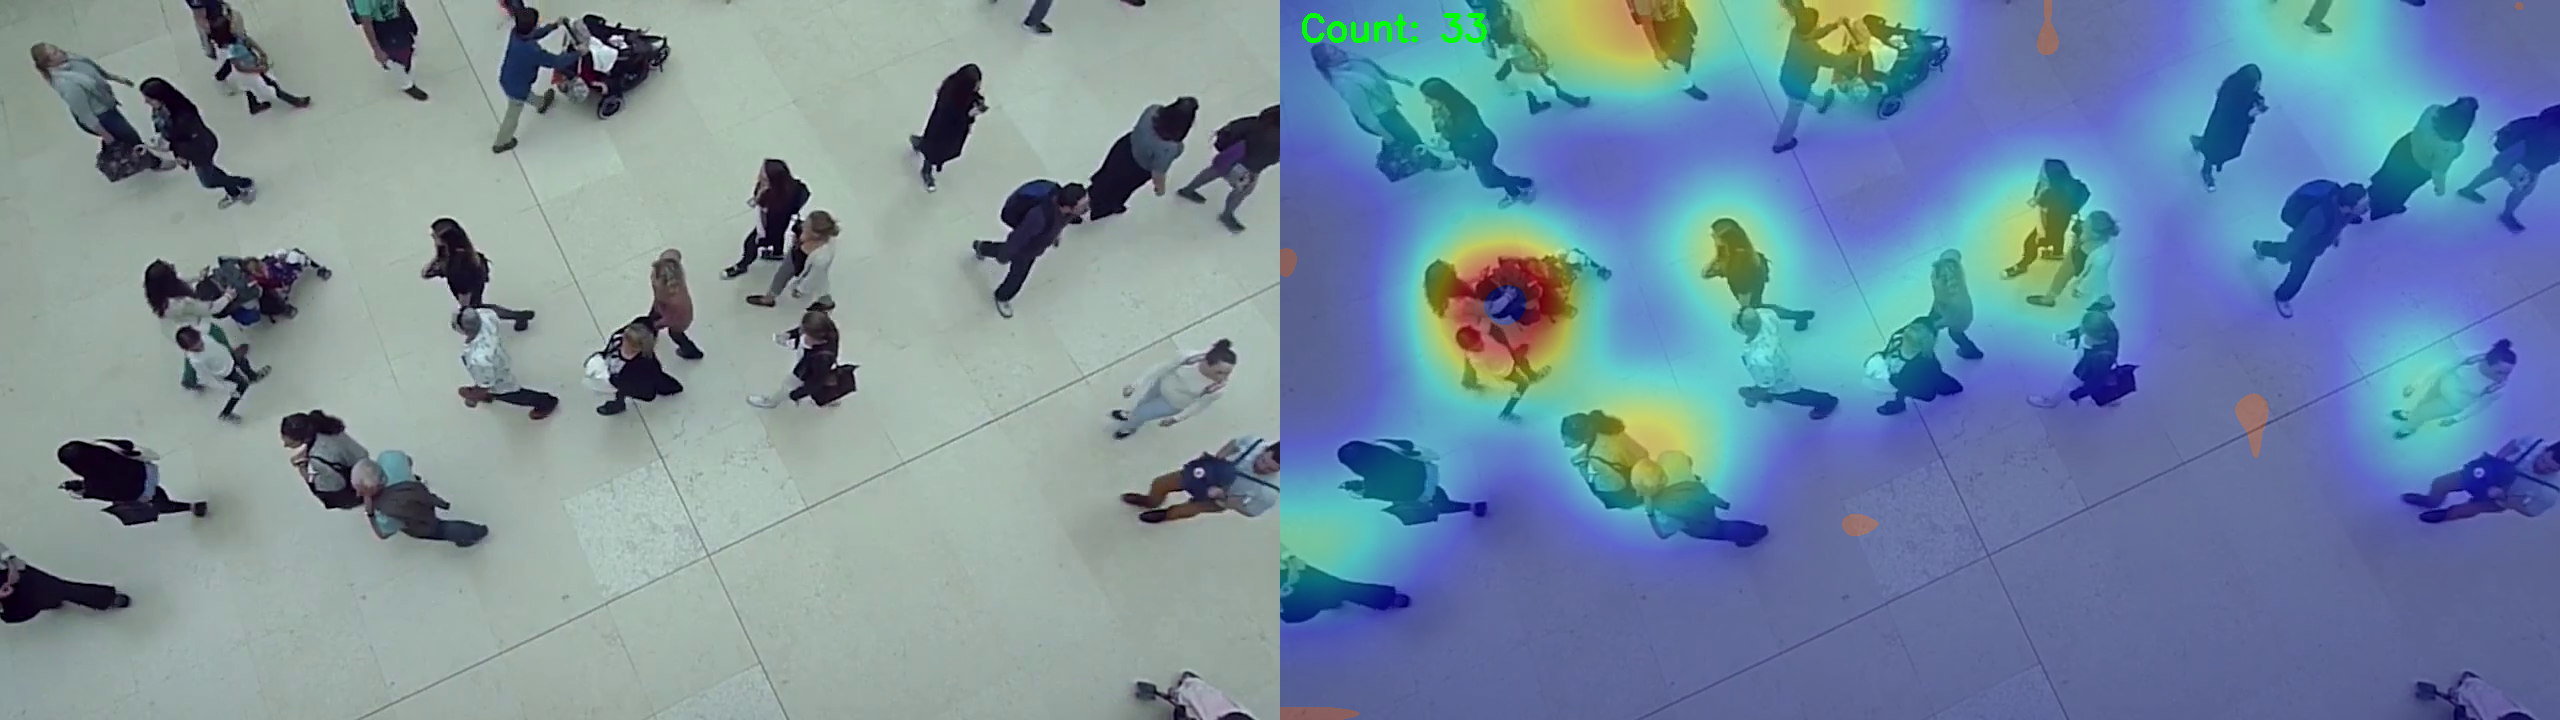

Left: Original frame | Right: Density map overlay


In [44]:
overlay = yolo_region_density(best_frame)

combined = np.hstack((best_frame, overlay))
combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

from PIL import Image
from IPython.display import display
display(Image.fromarray(combined_rgb))

print("Left: Original frame | Right: Density map overlay")
